In [1]:
#IMPORTS
import numpy as np
import os,sys,math
import matplotlib.pyplot as plt
sys.path.append(os.getcwd()+"/Code") # so that we can import the modules below
#feel free to have a look into Network, Layer or RBM implementations to see how they work
from NN import Network,Layer,pretrain_autoencoder,plot_results,plot_alphadigit_results
from RBM import RBM
from sklearn.model_selection import train_test_split
#DATASETS DIRECTORIES
MNIST_TRAIN_DIR="./Data/MNIST1_train.npz"
MNIST_TEST_1_DIR="./Data/MNIST1_test_1.npz"
PATCHES_DIR="./Data/PATCHES.npy"
ALPHADIGITS_DIR="./Data/binaryalphadigits.npz"

In [2]:
#An example how to create,train and use Network structure:
x_mock_data = np.array([[0,0],[0,1],[1,0],[1,1]])
y_mock_data = np.array([0,1,1,0])[:,None]

NN = Network([2,4,1],activations=["sigmoid"]) #define a network architecture & activation
NN.set_lr(1.0,momentum=0.0)  #set learning rate and momentum
NN.fit(x_mock_data,y_mock_data,batch_size=4, #fit to data
       epochs=2000,x_val=x_mock_data,y_true_val=y_mock_data) 
print("\n Targets:")
print((y_mock_data))
print("\n Predictions:")
print(NN.predict(x_mock_data)) # get predictions
print("\n Error:")
print(NN.evaluate(x_mock_data,y_mock_data)) # get error

2000:	 train err: 0.05839	 val err: 0.05825	 patience: 0	
 Targets:
[[0]
 [1]
 [1]
 [0]]

 Predictions:
[[0.18305374]
 [0.75130855]
 [0.77423557]
 [0.29437576]]

 Error:
[0.05824569]


### Load Mnist Dataset

In [3]:
#load the MNIST dataset
#train dataset for A1,A2,A3
X =  np.load(MNIST_TRAIN_DIR,allow_pickle=True)["arr_0"]
y =  np.load(MNIST_TRAIN_DIR,allow_pickle=True)["arr_1"]
#test dataset for A1,A2,A3
x_test =  np.load(MNIST_TEST_1_DIR,allow_pickle=True)["arr_0"]
y_test = np.load(MNIST_TEST_1_DIR,allow_pickle=True)["arr_1"]

#validation split
#create some validation data
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print("After train-valid split (80% Train - 20% Validation): ")
print("Train x shape:", x_train.shape, "\t Train y shape:", y_train.shape)
print("Valid x shape:", x_valid.shape, "\t Valid y shape:", y_valid.shape)
print("Test x shape:", x_test.shape, "\t Test y shape:", y_test.shape)

# Check if the data is normalized
print("\n The maximum value in this dataset: ", X.max(), "\n The minimum value in this dataset: ", X.min())

After train-valid split (80% Train - 20% Validation): 
Train x shape: (2400, 784) 	 Train y shape: (2400,)
Valid x shape: (600, 784) 	 Valid y shape: (600,)
Test x shape: (100, 784) 	 Test y shape: (100,)

 The maximum value in this dataset:  1.0 
 The minimum value in this dataset:  0.0



# Data Compression

## <span style="color:red">============= Assignment 1 =============</span>

**Question (a)**

The data set is divided into training set and verification set with the ratio 80%-20%. They will be used for training.

The AutoEncoder is trained by a three-layer network with the required hidden layer units. The number of input units and output units are the number of dimensions of data, i.e. 784. The hidden layer is the result of data compression. Tie the weights of the first layer and the third layer, as the same weight is used for encoding and decoding, in which the decoding is the transpose of the encoding weight. The input data is used as the real output value to calculate the loss and for network training.

**Question (b)**

150:	 train err: 0.01993	 val err: 0.02307	 patience: 3	

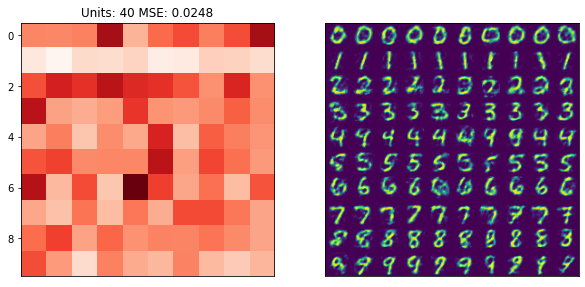

150:	 train err: 0.01031	 val err: 0.01468	 patience: 0	

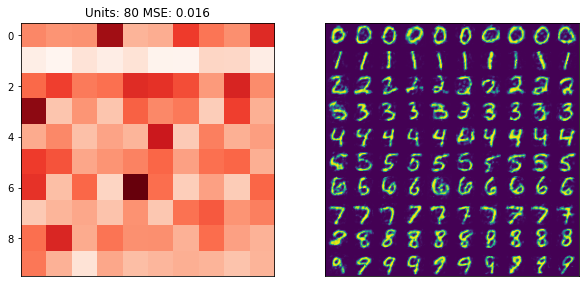

150:	 train err: 0.00367	 val err: 0.00761	 patience: 0	

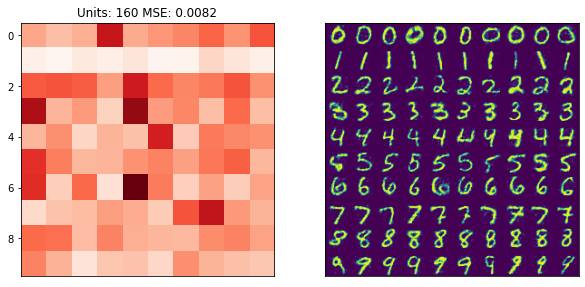

150:	 train err: 0.00184	 val err: 0.00431	 patience: 1	

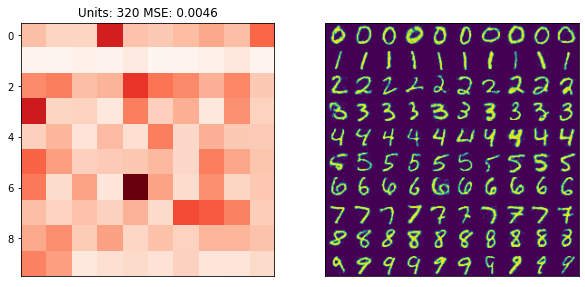

In [34]:
#Create a NN, tie its weights using the function:
#Network.tie_weights(layer_index_1,layer_index_2)
#Remember to do this before calling fit()!
#To visualize the results, use:
#plot_results(Network,data,hidden_units)
#Remember to record your results for Assignment 4!
hidden_arch = [40,80,160,320]

# Visible layers units
visible_nodes = x_train.shape[1]

# Initialize AE network architecture of different hidden layer units, put them in a list
tra_AE_list = []
for i in hidden_arch:
    curr_NN = Network(layer_units=[visible_nodes, i, visible_nodes], activations="sigmoid")
    curr_NN.set_lr(lr=1.0, momentum=0.0)
    curr_NN.tie_layer_weights(layer_a=1, layer_b=3)
    tra_AE_list.append(curr_NN)

# Record the MSE of different training
tra_AE_MSE = []
# Train the AE networks defined above
for i in range(len(tra_AE_list)):
    curr_NN = tra_AE_list[i]
    curr_NN.fit(x=x_train, y_true=x_train, x_val=x_valid, y_true_val=x_valid, batch_size=100, epochs=150, patience=25)
    tra_AE_MSE.append(plot_results(curr_NN, x_test=x_test, hidden_units=hidden_arch[i]))

**Question (c)**

The best AE is: 4, with the hidden units: 320, validation MSE: 0.004615

 Reconstructed images of 100 test instances created with the best AE


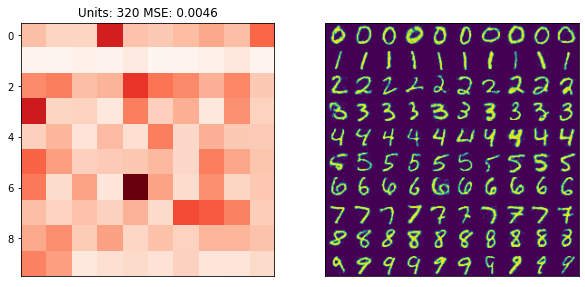

0.004614867516335341

In [57]:
# Show the informations of the best AE
best_idx = np.argmin(tra_AE_MSE)
print("The best AE is: %d, with the hidden units: %d, validation MSE: %f" %(best_idx+1, hidden_arch[best_idx], tra_AE_MSE[best_idx]))

# Reconstruct images of best AE
print("\n Reconstructed images of 100 test instances created with the best AE")
plot_results(tra_AE_list[best_idx], x_test=x_test, hidden_units=hidden_arch[best_idx])

## <span style="color:red">============= End of Assignment 1 =============</span>

## <span style="color:red">============= Assignment 2 =============</span>

**Question (a)**

Add the noise with mean value of 0 and standard deviation of 0.1 to the training data. The rest are consistent with Assignment1 question(a)

**Question (b)**

In [48]:
#Train a DAE
#add gaussian noise to data 
hidden_arch = [40,80,160,320]

# Generate noise and add to training data
loc = 0
scale = 0.1
gaus_noise = np.random.normal(loc, scale, x_train.shape)
x_train_noise = x_train + gaus_noise

# Clip the data in range [0,1]
clip = lambda x: 0 if x < 0 else 1 if x > 1 else x
for i in range(len(x_train_noise)):
    for j in range(len(x_train_noise[i])):
        x_train_noise[i][j] = clip(x_train_noise[i][j])

108:	 train err: 0.02136	 val err: 0.02647	 patience: 25	
 Patience condition reached,best validation performance: 0.02541635944908619


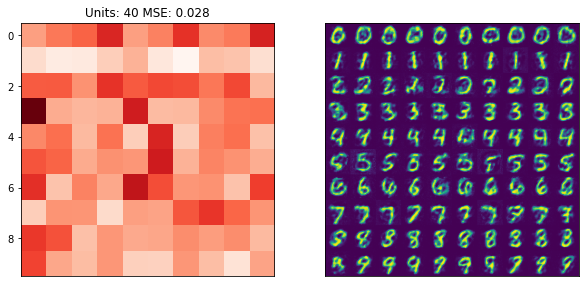

150:	 train err: 0.01234	 val err: 0.01706	 patience: 9	

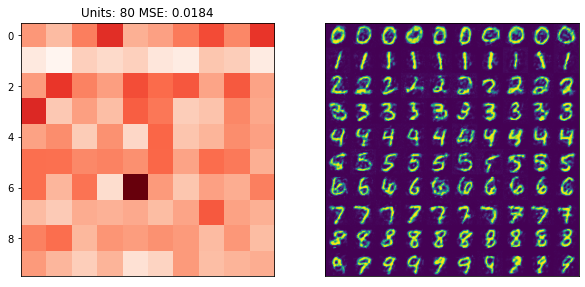

150:	 train err: 0.00669	 val err: 0.00862	 patience: 9	

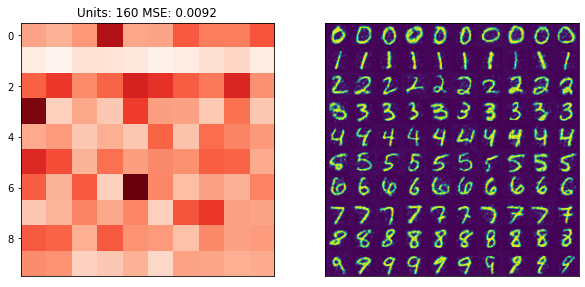

150:	 train err: 0.00463	 val err: 0.00554	 patience: 2	

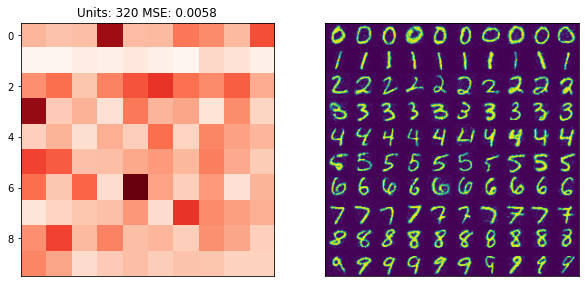

In [51]:
# Visible layers units
visible_nodes = x_train_noise.shape[1]

# Initialize DAE network architecture of different hidden layer units, put them in a list
DAE_list = []
for i in hidden_arch:
    curr_NN = Network(layer_units=[visible_nodes, i, visible_nodes], activations="sigmoid")
    curr_NN.set_lr(lr=1.0, momentum=0.0)
    curr_NN.tie_layer_weights(layer_a=1, layer_b=3)
    DAE_list.append(curr_NN)

# Record the MSE of different training
DAE_MSE = []
# Train the DAE networks defined above
for i in range(len(DAE_list)):
    curr_NN = DAE_list[i]    
    curr_NN.fit(x=x_train_noise, y_true=x_train_noise, x_val=x_valid, y_true_val=x_valid, batch_size=100, epochs=150, patience=25)

    DAE_MSE.append(plot_results(curr_NN, x_test=x_test, hidden_units=hidden_arch[i]))

**Question (c)**

The best AE is: 4, with the hidden units: 320, validation MSE: 0.005790

 Reconstructed images of 100 test instances created with the best AE


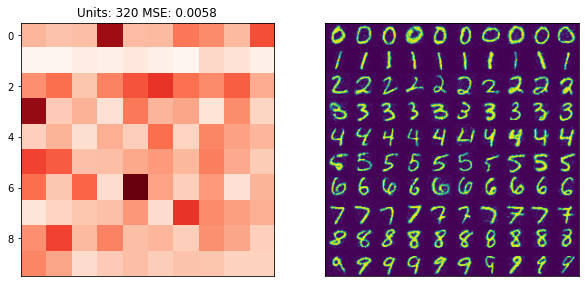

0.005789673704416467

In [56]:
# Show the informations of the best DAE
best_idx = np.argmin(DAE_MSE)
print("The best AE is: %d, with the hidden units: %d, validation MSE: %f" %(best_idx+1, hidden_arch[best_idx], DAE_MSE[best_idx]))

# Reconstruct images of best DAE
print("\n Reconstructed images of 100 test instances created with the best AE")
plot_results(DAE_list[best_idx], x_test=x_test, hidden_units=hidden_arch[best_idx])

## <span style="color:red">============= End of Assignment 2 =============</span>

## <span style="color:red">============= Assignment 3 =============</span>

**Question (a)**


Using RBM, there is only one input layer and one hidden layer. It does not need to tie weights as it uses a bidirectional weight matrix. Other descriptions are the same as Assignment 1 Question (a)

**Question (b)**

121:	 train err: 0.04237	 val err: 0.04251	 patience: 25	
 Patience condition reached,best validation performance: 0.04208988208409729


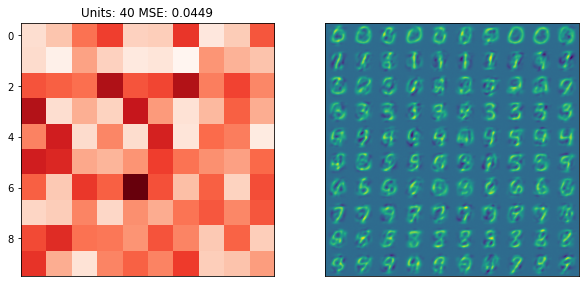

91:	 train err: 0.04403	 val err: 0.04403	 patience: 25	
 Patience condition reached,best validation performance: 0.04355993924146615


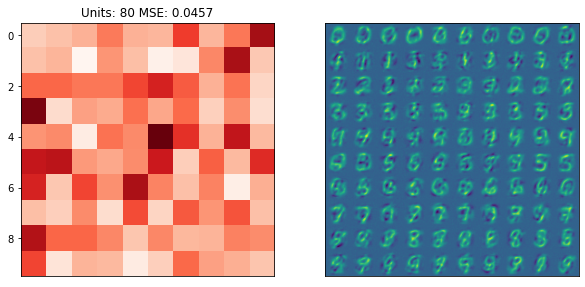

65:	 train err: 0.04595	 val err: 0.04663	 patience: 25	
 Patience condition reached,best validation performance: 0.045216112516675365


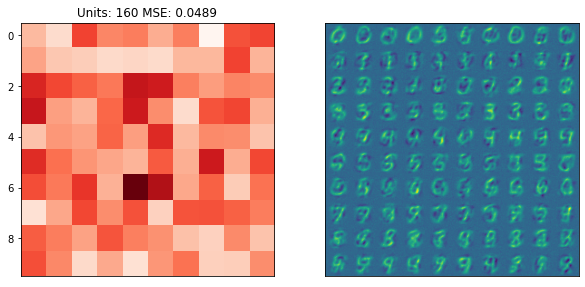

51:	 train err: 0.0501	 val err: 0.0501	 patience: 25	
 Patience condition reached,best validation performance: 0.04930712047563335


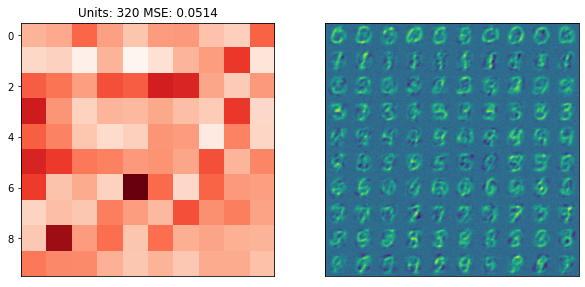

In [64]:
#Here use the RBM class to obtain your results.
#The RBM has to have gaussian visible and binomial hidden units
hidden_arch = [40,80,160,320]

# Visible layers units
visible_nodes = x_train.shape[1]

# Initialize RBM network architecture of different hidden layer units, put them in a list
RBM_list = []
for i in hidden_arch:
    curr_NN = RBM(n_vis=visible_nodes, n_hid=i, use_gaussian_visible_sampling=True)
    curr_NN.set_lr(lr=0.01, momentum=0.5)
    RBM_list.append(curr_NN)

# Record the RBM of different training
RBM_MSE = []
# Train the RBM networks defined above
for i in range(len(RBM_list)):
    curr_NN = RBM_list[i]
    curr_NN.fit(x=x_train, x_val=x_valid, batch_size=100, epochs=1500, patience=25)

    RBM_MSE.append(plot_results(curr_NN, x_test=x_test, hidden_units=hidden_arch[i]))

**Question (c)**

The best AE is: 1, with the hidden units: 40, validation MSE: 0.044943

 Reconstructed images of 100 test instances created with the best AE


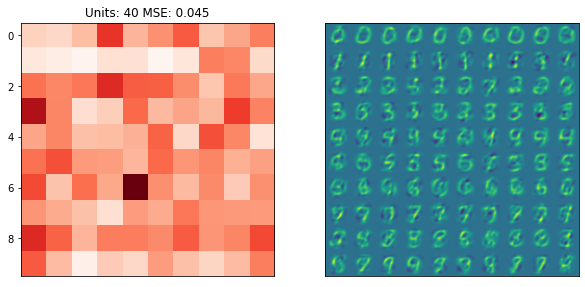

0.04500673449758174

In [88]:
# Show the informations of the best DAE
best_idx = np.argmin(RBM_MSE)
print("The best AE is: %d, with the hidden units: %d, validation MSE: %f" %(best_idx+1, hidden_arch[best_idx], RBM_MSE[best_idx]))

# Reconstruct images of best DAE
print("\n Reconstructed images of 100 test instances created with the best AE")
plot_results(RBM_list[best_idx], x_test=x_test, hidden_units=hidden_arch[best_idx])

## <span style="color:red">============= End of Assignment 3 =============</span>

## <span style="color:red">============= Assignment 4 =============</span>


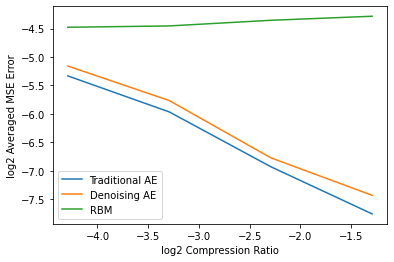

In [96]:
#Create a plot comparing compression power of different AE
compre_ratio = np.log2(np.asarray(hidden_arch) / x_train.shape[1])

plt.plot(compre_ratio, np.log2(tra_AE_MSE), label="Traditional AE")
plt.plot(compre_ratio, np.log2(DAE_MSE), label="Denoising AE")
plt.plot(compre_ratio, np.log2(RBM_MSE), label="RBM")
plt.legend()
plt.xlabel("log2 Compression Ratio")
plt.ylabel("log2 Averaged MSE Error")
plt.show()

## <span style="color:red">============= End of Assignment 4 =============</span>

## <span style="color:red">============= Assignment 5 =============</span>


**Description**: For input and output layers, i.e. visible layers, MNIST dataset is more like binary distribution because its value range is [0,1]. Therefore, set *use_gaussian_visible_sampling* parameter to false. In addition, as these input values are combined with the weight into the hidden layer, it is closer to the Gaussian distribution, so use_gaussian_hidden_sampling is set to true

144:	 train err: 0.01225	 val err: 0.0133	 patience: 25	
 Patience condition reached,best validation performance: 0.013183971353931567


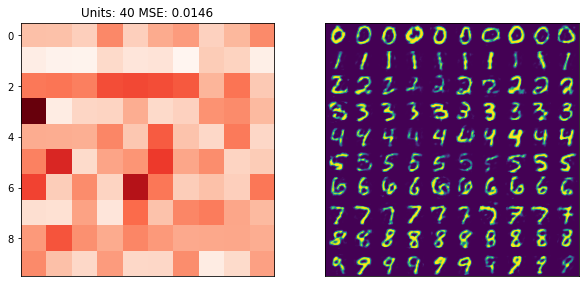

259:	 train err: 0.00857	 val err: 0.00977	 patience: 25	
 Patience condition reached,best validation performance: 0.009550194554996247


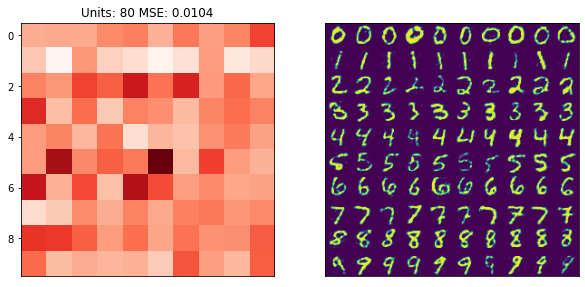

239:	 train err: 0.0083	 val err: 0.0093	 patience: 25	
 Patience condition reached,best validation performance: 0.009286973319278633


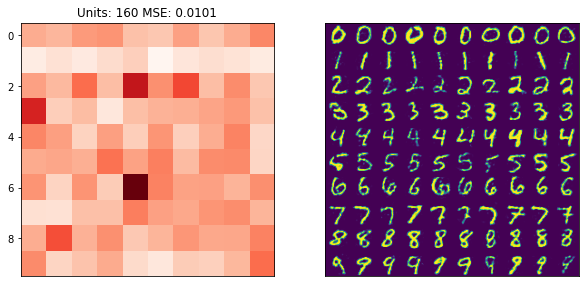

290:	 train err: 0.00823	 val err: 0.00925	 patience: 25	
 Patience condition reached,best validation performance: 0.009122419568995038


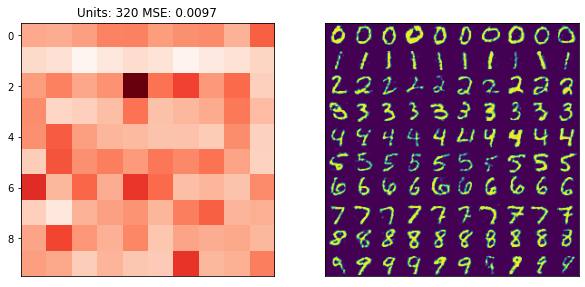

In [5]:
#If you have any idea for improvement, start working from here.

#Here use the RBM class to obtain your results.
#The RBM has to have gaussian visible and binomial hidden units
hidden_arch = [40,80,160,320]

# Visible layers units
visible_nodes = x_train.shape[1]

# Initialize RBM network architecture of different hidden layer units, put them in a list
RBM_list = []
for i in hidden_arch:
    curr_NN = RBM(n_vis=visible_nodes, n_hid=i, use_gaussian_visible_sampling=False, use_gaussian_hidden_sampling=True)
    curr_NN.set_lr(lr=0.01, momentum=0.5)
    RBM_list.append(curr_NN)

# Record the RBM of different training
RBM_MSE = []
# Train the RBM networks defined above
for i in range(len(RBM_list)):
    curr_NN = RBM_list[i]
    curr_NN.fit(x=x_train, x_val=x_valid, batch_size=100, epochs=1500, patience=25)

    RBM_MSE.append(plot_results(curr_NN, x_test=x_test, hidden_units=hidden_arch[i]))

The best AE is: 4, with the hidden units: 320, validation MSE: 0.009675

 Reconstructed images of 100 test instances created with the best AE


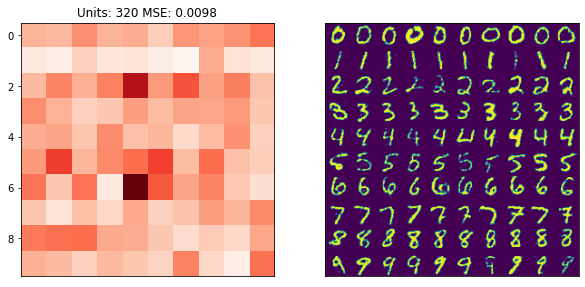

0.009842047000598849

In [6]:
# Show the informations of the best DAE
best_idx = np.argmin(RBM_MSE)
print("The best AE is: %d, with the hidden units: %d, validation MSE: %f" %(best_idx+1, hidden_arch[best_idx], RBM_MSE[best_idx]))

# Reconstruct images of best DAE
print("\n Reconstructed images of 100 test instances created with the best AE")
plot_results(RBM_list[best_idx], x_test=x_test, hidden_units=hidden_arch[best_idx])

## <span style="color:red">============= End of Assignment 5 =============</span>

# Spatial Filer Learning

## <span style="color:red">============= Assignment 6 =============</span>


**Question (b)**

In [16]:
#Complete the for loop from the diplay_filters function that visualizes the NN weights.
#To access any Network weights, use the following syntax: 
#Network.layers[layer_index].w
def display_mean_activation(nn,x,n_units=50):
    """
    Plots a scatter plot of mean activation of the first n_units neurons of the first hidden layer.
    nn - a Network class object
    x - data on which to measure the mean activation
    n_units - how many activation are meant to be displayed
    """
    plt.figure(figsize=(5,5))
    #COMPLETE BELOW
    # Get the first n_units neurons values 
    activations = nn.get_layer_output(x=x, n=2)[:,0:n_units]
    # Compute the mean activation
    mean_activations = activations.mean(axis=0)
    plt.scatter( [i for i in range(n_units)], mean_activations )
    plt.xlim(int(-n_units/10),int(n_units+n_units/6))
    plt.xlabel("Hidden units")
    plt.ylabel("Mean activation")
    plt.show()

def display_filters(nn):
    """
    Complete a function that visualizes the weights inside
    the second hidden layer of the nn in a 10x10 grid.
    Use the plt.subplot() to create 100 subplots.
    nn - a Network class object
    """
    plt.figure(figsize=(7,7))
    for i in range(100):
        #COMPLETE BELOW, IT CAN TAKE MORE OR LESS LINES THEN 3
        plt.subplot(10,10,i+1)
        # Get the weights of layer 1
        w_i = np.reshape((nn.layers[1].w.T)[i], (8,8))
        plt.imshow(w_i,cmap="bwr")
        plt.axis=('off')        
    plt.show()

**Question (a)**

In [17]:
#Load and preprocess the dataset
X_patches = np.load(PATCHES_DIR,allow_pickle=True)
#Here, you have to preprocess the dataset
def data_norm(data):
    return data/255

# Normalization and reshape to two dimension, i.e., (100000, 64)
X_patches_norm = data_norm(X_patches).reshape( (X_patches.shape[0], X_patches.shape[1]*X_patches.shape[2]) )

# Train-valid-test split
X_patches_norm_train, X_patches_norm_valid = train_test_split(X_patches_norm, test_size=0.15, random_state=42)
X_patches_norm_train, X_patches_norm_test = train_test_split(X_patches_norm_train, test_size=0.2, random_state=42)

**Question (c)**

0: Input	 in:(None, 64)	 out:(None, 64)
1: Dense	 in:(None, 64)	 out:(None, 100)
2: Sigmoid	 in:(None, 100)	 out:(None, 100)
3: Dense	 in:(None, 100)	 out:(None, 64)
4: Sigmoid	 in:(None, 64)	 out:(None, 64)
13:	 train err: 0.03069	 val err: 0.02999	 patience: 10	
 Patience condition reached,best validation performance: 0.02917466264599304


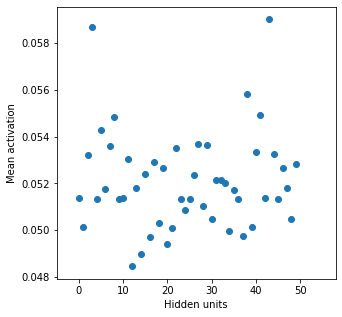

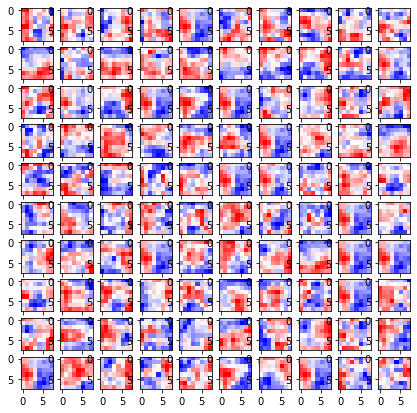

60:	 train err: 0.00529	 val err: 0.0049	 patience: 2	

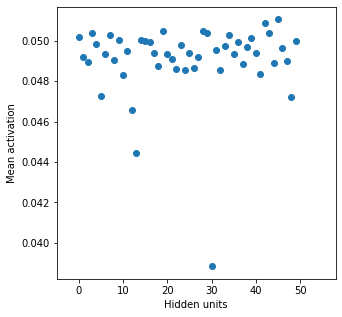

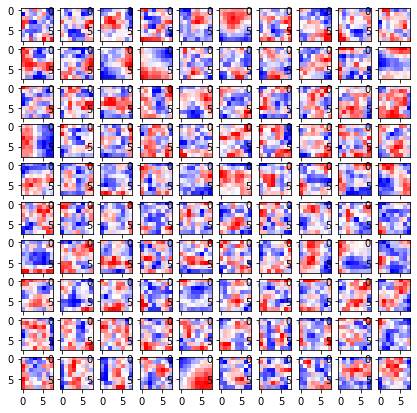

60:	 train err: 0.00412	 val err: 0.00405	 patience: 0	

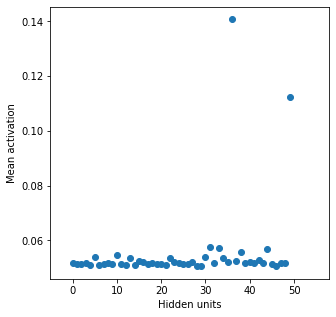

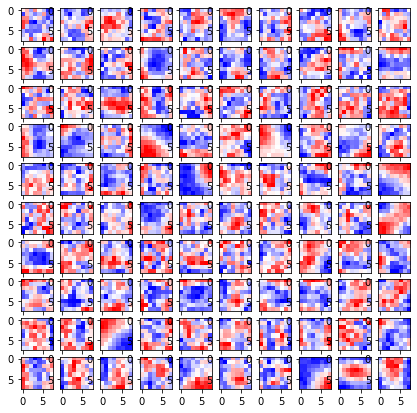

In [31]:
#Do some hyperpaameter search for lambda and rho here.
# To enable sparisty, use:
# Netowrk.layers[activation_layer_id].enable sparsity(lambda,rho)
#Use Network.get_summary() to print network layers' summary
#Use display_mean_acitvation and display_filters to visualize your results
sparse_param = [[0.5, 0.05], [0.1, 0.05], [0.005, 0.05]]
SAE_list = []
for i in sparse_param:
    curr_NN = Network(layer_units=[64,100,64], activations=["sigmoid"])
    curr_NN.layers[2].enable_sparsity(beta=i[0], p=i[1])
    curr_NN.set_lr(1.0, momentum=0.5)
    SAE_list.append(curr_NN)
SAE_list[0].get_summary()

for i in range(len(SAE_list)):
    curr_NN = SAE_list[i]
    curr_NN.fit(x=X_patches_norm_train, y_true=X_patches_norm_train, x_val=X_patches_norm_valid, y_true_val=X_patches_norm_valid, batch_size=500, epochs=60, patience=10)
    display_mean_activation(curr_NN, X_patches_norm_test, 50)
    display_filters(curr_NN)

The best parameters are: p=0.05, $\lambda$=0.5

## <span style="color:red">============= End of Assignment 6 =============</span>

# Visualization

## <span style="color:red">============= Assignment 7 =============</span>

**Question (a)**

1. Train-Valid-Test data split
2. Create and pretrain RBM model
3. Create new network architectures and use the weights of pre-trained RBM model
4. Fine tune

In [2]:
# Load the data for the current assignment: binary alphadigits dataset.
# Please apply any data preprocessing / splitting in this cell.
alphadigits_data = np.load(ALPHADIGITS_DIR,allow_pickle=True)
X_adig = alphadigits_data['X']
y_adig = alphadigits_data['y_labels']

temp = []
idx_count = 0
for i in y_adig:
    for j in range(X_adig[idx_count].shape[0]):
        temp.append(i)
    idx_count+=1
y_adig = np.asarray(temp)

X_adig = X_adig.reshape( X_adig.shape[0]*X_adig.shape[1], X_adig.shape[2]*X_adig.shape[3] )

print("X_adig shape:", X_adig.shape)
print("y_adig shape:", y_adig.shape)

X_adig_train, X_adig_test, y_adig_train, y_adig_test = train_test_split(
    X_adig, y_adig, test_size=0.33, random_state=0,shuffle=True,stratify=y_adig)

print("X_adig_train shape before valid split:", X_adig_train.shape)
print("y_adig_train shape before valid split:", y_adig_train.shape)

X_adig_train, X_adig_valid, y_adig_train, y_adig_valid = train_test_split(X_adig_train, y_adig_train, test_size=0.15, random_state=0)
print("X_adig_train:", X_adig_train.shape)
print("X_adig_valid:", X_adig_valid.shape)

X_adig shape: (1404, 320)
y_adig shape: (1404,)
X_adig_train shape before valid split: (940, 320)
y_adig_train shape before valid split: (940,)
X_adig_train: (799, 320)
X_adig_valid: (141, 320)


In [3]:
# Define the pretrained the RBM architecture
layer_units_list = [320,250,150,50,25,2,25,50,150,250,320]
activations_list = ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "linear", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid"]

pretain_NN = Network(layer_units=layer_units_list, activations=activations_list)

pretain_NN.get_summary()

0: Input	 in:(None, 320)	 out:(None, 320)
1: Dense	 in:(None, 320)	 out:(None, 250)
2: Sigmoid	 in:(None, 250)	 out:(None, 250)
3: Dense	 in:(None, 250)	 out:(None, 150)
4: Sigmoid	 in:(None, 150)	 out:(None, 150)
5: Dense	 in:(None, 150)	 out:(None, 50)
6: Sigmoid	 in:(None, 50)	 out:(None, 50)
7: Dense	 in:(None, 50)	 out:(None, 25)
8: Sigmoid	 in:(None, 25)	 out:(None, 25)
9: Dense	 in:(None, 25)	 out:(None, 2)
10: Linear	 in:(None, 2)	 out:(None, 2)
11: Dense	 in:(None, 2)	 out:(None, 25)
12: Sigmoid	 in:(None, 25)	 out:(None, 25)
13: Dense	 in:(None, 25)	 out:(None, 50)
14: Sigmoid	 in:(None, 50)	 out:(None, 50)
15: Dense	 in:(None, 50)	 out:(None, 150)
16: Sigmoid	 in:(None, 150)	 out:(None, 150)
17: Dense	 in:(None, 150)	 out:(None, 250)
18: Sigmoid	 in:(None, 250)	 out:(None, 250)
19: Dense	 in:(None, 250)	 out:(None, 320)
20: Sigmoid	 in:(None, 320)	 out:(None, 320)


In [4]:
# Pretrain the RBM
pretrain_autoencoder(net=pretain_NN, x=X_adig_train, x_val=X_adig_valid, rbm_lr=0.1,
                         rbm_use_gauss_hidden=False,
                         rbm_mom=0.5,
                         rbm_batch_size=64,
                         rbm_epochs=300, rbm_patience=40)


Fine tuning layer number 0
206:	 train err: 0.00886	 val err: 0.061	 patience: 40	9		
 Patience condition reached,best validation performance: 0.058975474518809905

Fine tuning layer number 1
150:	 train err: 0.02378	 val err: 0.04828	 patience: 40		
 Patience condition reached,best validation performance: 0.04749992439039728

Fine tuning layer number 2
258:	 train err: 0.0559	 val err: 0.06764	 patience: 40					
 Patience condition reached,best validation performance: 0.06484258133023513

Fine tuning layer number 3
245:	 train err: 0.07166	 val err: 0.07414	 patience: 40				
 Patience condition reached,best validation performance: 0.07224991659286713

Fine tuning layer number 4
126:	 train err: 0.16494	 val err: 0.16459	 patience: 40	
 Patience condition reached,best validation performance: 0.16114512644682466
Pre training finished!


In [5]:
lr_list = [0.01, 0.03, 0.07, 0.05] + [i/10 for i in range(1,6,1)]
# Create networks using pretrained RBM model weights
NN_list = []
for i in range(len(lr_list)):
    temp_NN = Network(layer_units=layer_units_list, activations=activations_list, copy_net=pretain_NN)
    NN_list.append(temp_NN)

# Train the networks defined above
idx_count = 0
for i in lr_list:
    front_pointer = 1
    back_pointer = len(pretain_NN.layers)-1-1
    temp_NN = NN_list[idx_count]
    while front_pointer < back_pointer:
        temp_NN.tie_layer_weights(front_pointer, back_pointer)
        front_pointer += 2
        back_pointer -= 2

    print("Learning rate =", i)
    temp_NN.set_lr(lr=i, momentum=0.5)
    temp_NN.fit(x=X_adig_train, y_true=X_adig_train, x_val=X_adig_valid, y_true_val=X_adig_valid, batch_size=64, epochs=300, patience=40)
    
    idx_count += 1
    print("\n")


Learning rate = 0.01
300:	 train err: 0.18265	 val err: 0.21809	 patience: 17		

Learning rate = 0.03
154:	 train err: 0.17961	 val err: 0.21552	 patience: 40	
 Patience condition reached,best validation performance: 0.21257921127181273


Learning rate = 0.07
81:	 train err: 0.17982	 val err: 0.22162	 patience: 40	
 Patience condition reached,best validation performance: 0.21494049621001404


Learning rate = 0.05
108:	 train err: 0.18021	 val err: 0.21549	 patience: 40	
 Patience condition reached,best validation performance: 0.20988358445075211


Learning rate = 0.1
83:	 train err: 0.17814	 val err: 0.21019	 patience: 40	
 Patience condition reached,best validation performance: 0.20554316322029642


Learning rate = 0.2
128:	 train err: 0.20492	 val err: 0.21326	 patience: 40	
 Patience condition reached,best validation performance: 0.20281306738332727


Learning rate = 0.3
88:	 train err: 0.20653	 val err: 0.20957	 patience: 40		
 Patience condition reached,best validation performance

The best learning rate is: 0.3


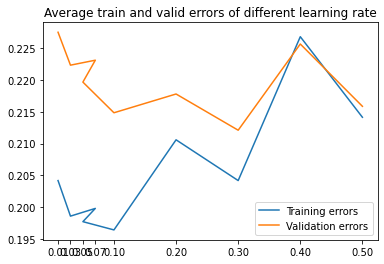

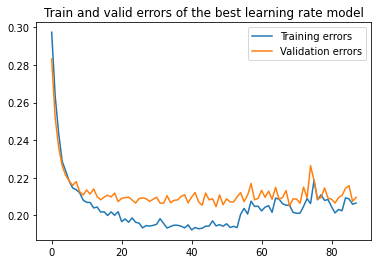

In [6]:
train_err_list = []
val_err_list = []
for i in NN_list:
    train_err_list.append(np.mean(i.train_err_hist))
    val_err_list.append(np.mean(i.val_err_hist))

best_idx = np.argmin(val_err_list)
best_ft = NN_list[best_idx]
print("The best learning rate is:", lr_list[best_idx])

plt.plot(lr_list, train_err_list, label="Training errors")
plt.plot(lr_list, val_err_list, label="Validation errors")
plt.xticks(lr_list)
plt.legend()
plt.title("Average train and valid errors of different learning rate")
plt.show()

plt.plot(NN_list[best_idx].train_err_hist, label="Training errors")
plt.plot(NN_list[best_idx].val_err_hist, label="Validation errors")
plt.title("Train and valid errors of the best learning rate model")
plt.legend()
plt.show()

**Question (b)**

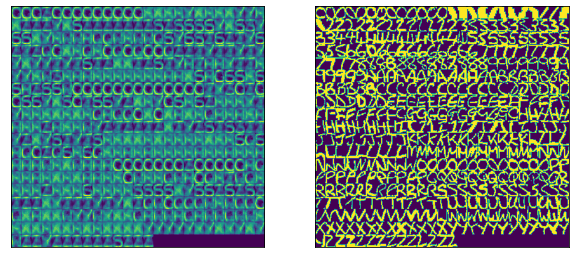

0.20836014159623864

In [7]:
plot_alphadigit_results(model=NN_list[best_idx], X=X_adig_test, labels=y_adig_test)

**Question (c)**

In [7]:
def get_color(char):
    colorSet = {
        "1": "black",
        "2": "darkgray",
        "3": "lightcoral",
        "4": "brown",
        "5": "red",
        "6": "mistyrose",
        "7": "tomato",
        "8": "sienna",
        "9": "peachpuff",
        "A": "bisque",
        "B": "darkorange",
        "C": "burlywood",
        "D": "darkgoldenrod",
        "E": "gold",
        "F": "olive",
        "G": "yellow",
        "H": "olivedrab",
        "I": "yellowgreen",
        "J": "lightgreen",
        "K": "forestgreen",
        "L": "springgreen",
        "M": "dodgerblue",
        "N": "teal",
        "O": "aqua",
        "P": "cornflowerblue",
        "Q": "lavender",
        "R": "darkblue",
        "S": "mediumpurple",
        "T": "mediumorchid",
        "U": "violet",
        "V": "pink",
        "W": "deeppink",
        "X": "purple",
        "Y": "palevioletred",
        "Z": "plum"

    }
    return colorSet.get(char)

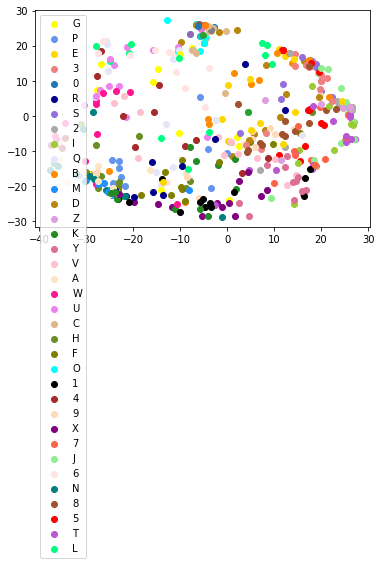

In [10]:
points = NN_list[best_idx].get_layer_output(x=X_adig_test, n=9)

printed_labels = []
for i in range(len(points)):
    curr_label = y_adig_test[i]
    if curr_label not in printed_labels:
        plt.scatter(points[i,0], points[i,1], c=get_color(y_adig_test[i]), label=curr_label)
        printed_labels.append(curr_label)
        continue
    plt.scatter(points[i,0], points[i,1], c=get_color(y_adig_test[i]))

plt.legend()
plt.show()

In [33]:
sorted_points = []
visited_labels = []
for i in range(len(y_adig_test)):
    curr_label = y_adig_test[i]
    if curr_label not in visited_labels:
        for j in range(len(y_adig_test)):
            if y_adig_test[j] == y_adig_test[i]:
                sorted_points.append(points[j])
        visited_labels.append(y_adig_test[i])

sorted_points = np.asarray(sorted_points)

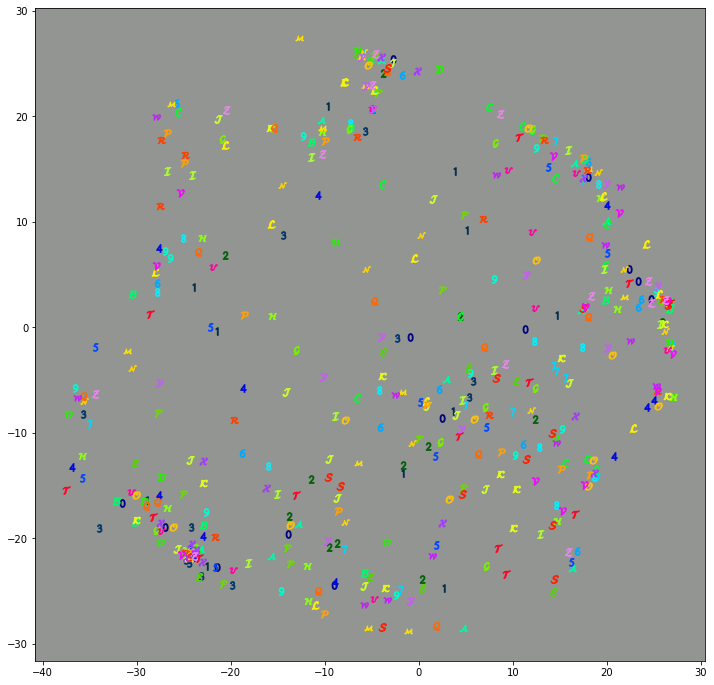

In [50]:
#Plot the 2D digit representations on a scatter plot from the x_test_2 dataset.
#Remember to use different colours for different digits!
y_adig_test = list(y_adig_test)
y_adig_test.sort()
label_pos = []
visited_labels = []
for i in range(len(y_adig_test)):
    if y_adig_test[i] not in visited_labels:
        label_pos.append(i)
        visited_labels.append(y_adig_test[i])
check_idx = lambda x: label_pos[x] if x<len(label_pos) else len(y_adig_test)

plt.figure(figsize=(12,12))
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired
colors = [colormap(i) for i in np.linspace(0, 0.9,36)]
for i in range(36):
    plt.scatter(sorted_points[check_idx(i) : check_idx(i+1)][:,0],
                sorted_points[check_idx(i) : check_idx(i+1)][:,1],
                label=str(i),
                s=60,
                marker='$\mathcal{'+y_adig[39*i]+'}$',
                c=np.array(colors[i]).reshape(1,-1),
                alpha=0.9)
ax = plt.gca()
ax.set_facecolor('xkcd:grey')
plt.show()


## <span style="color:red">============= End of Assignment 7 =============</span>

## <span style="color:red">============= Assignment 8 =============</span>

In [8]:
#Create and train another network, this time without pretraining.
#You can use the plot_results function to see the results.
layer_units_list = [320,250,150,50,25,2,25,50,150,250,320]
activations_list = ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "linear", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid"]

lr_list = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1, 1.5]
NN_list = []
for i in range(len(lr_list)):
    temp_NN = Network(layer_units=layer_units_list, activations=activations_list)
    NN_list.append(temp_NN)

idx_count = 0
for i in lr_list:
    front_pointer = 1
    back_pointer = len(NN_list[0].layers)-1-1
    temp_NN = NN_list[idx_count]
    while front_pointer < back_pointer:
        temp_NN.tie_layer_weights(front_pointer, back_pointer)
        front_pointer += 2
        back_pointer -= 2

    print("Learning rate =", i)
    temp_NN.set_lr(lr=i, momentum=0.5)
    temp_NN.fit(x=X_adig_train, y_true=X_adig_train, x_val=X_adig_valid, y_true_val=X_adig_valid, batch_size=64, epochs=300, patience=40)
    
    idx_count += 1
    print("\n")

Learning rate = 0.01
100:	 train err: 0.23212	 val err: 0.23008	 patience: 40	
 Patience condition reached,best validation performance: 0.2300258819973342


Learning rate = 0.05
81:	 train err: 0.23194	 val err: 0.23018	 patience: 40		
 Patience condition reached,best validation performance: 0.229978381661113


Learning rate = 0.1
81:	 train err: 0.23185	 val err: 0.23013	 patience: 40	
 Patience condition reached,best validation performance: 0.23000382342302528


Learning rate = 0.3
56:	 train err: 0.23213	 val err: 0.23003	 patience: 40	
 Patience condition reached,best validation performance: 0.22998704858124724


Learning rate = 0.5
162:	 train err: 0.21196	 val err: 0.21124	 patience: 40			
 Patience condition reached,best validation performance: 0.19671312484062203


Learning rate = 0.7
205:	 train err: 0.23359	 val err: 0.23193	 patience: 40		
 Patience condition reached,best validation performance: 0.20035937582361715


Learning rate = 1
113:	 train err: 0.23274	 val err: 0.230

The best learning rate is: 0.5


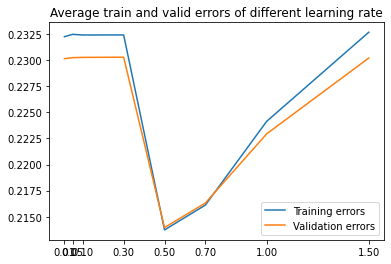

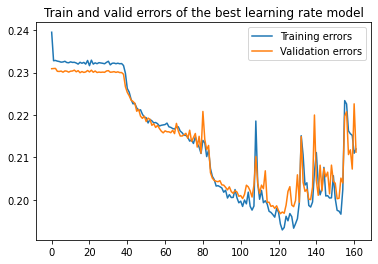

In [9]:
train_err_list = []
val_err_list = []
for i in NN_list:
    train_err_list.append(np.mean(i.train_err_hist))
    val_err_list.append(np.mean(i.val_err_hist))

best_idx = np.argmin(val_err_list)
best_ini = NN_list[best_idx]
print("The best learning rate is:", lr_list[best_idx])

plt.plot(lr_list, train_err_list, label="Training errors")
plt.plot(lr_list, val_err_list, label="Validation errors")
plt.xticks(lr_list)
plt.legend()
plt.title("Average train and valid errors of different learning rate")
plt.show()

plt.plot(NN_list[best_idx].train_err_hist, label="Training errors")
plt.plot(NN_list[best_idx].val_err_hist, label="Validation errors")
plt.title("Train and valid errors of the best learning rate model")
plt.legend()
plt.show()

**Question (a)**

The learning rate is set to [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1, 1.5], and the model with the smallest MSE is the best model. As can be seen from the above figure, the model is the best when the learning rate is 0.5, and the validation error is the lowest.

**Question (b)**

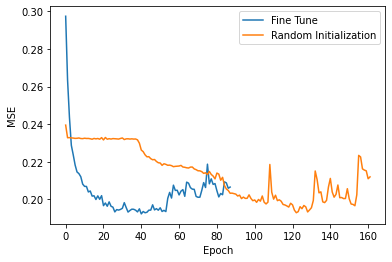

In [15]:
#Create a plot of training metrics.
plt.plot(best_ft.train_err_hist, label="Fine Tune")
plt.plot(best_ini.train_err_hist, label="Random Initialization")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

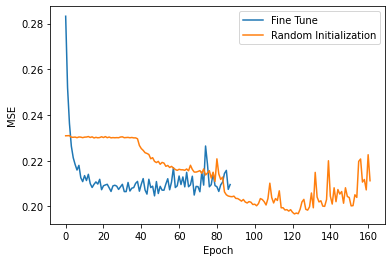

In [16]:
plt.plot(best_ft.val_err_hist, label="Fine Tune")
plt.plot(best_ini.val_err_hist, label="Random Initialization")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

**Question (c)**

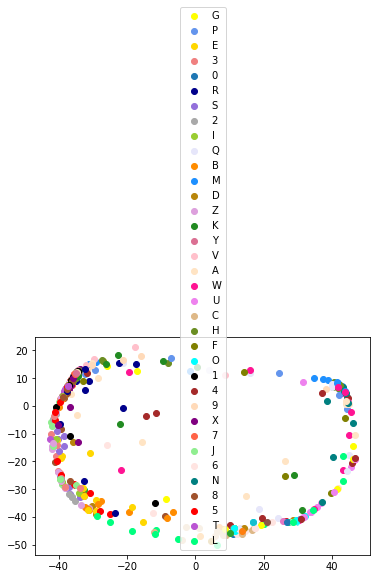

In [8]:
points = NN_list[best_idx].get_layer_output(x=X_adig_test, n=9)

printed_labels = []
for i in range(len(points)):
    curr_label = y_adig_test[i]
    if curr_label not in printed_labels:
        plt.scatter(points[i,0], points[i,1], c=get_color(y_adig_test[i]), label=curr_label)
        printed_labels.append(curr_label)
        continue
    plt.scatter(points[i,0], points[i,1], c=get_color(y_adig_test[i]))

plt.legend()
plt.show()

In [9]:
sorted_points = []
visited_labels = []
for i in range(len(y_adig_test)):
    curr_label = y_adig_test[i]
    if curr_label not in visited_labels:
        for j in range(len(y_adig_test)):
            if y_adig_test[j] == y_adig_test[i]:
                sorted_points.append(points[j])
        visited_labels.append(y_adig_test[i])

sorted_points = np.asarray(sorted_points)

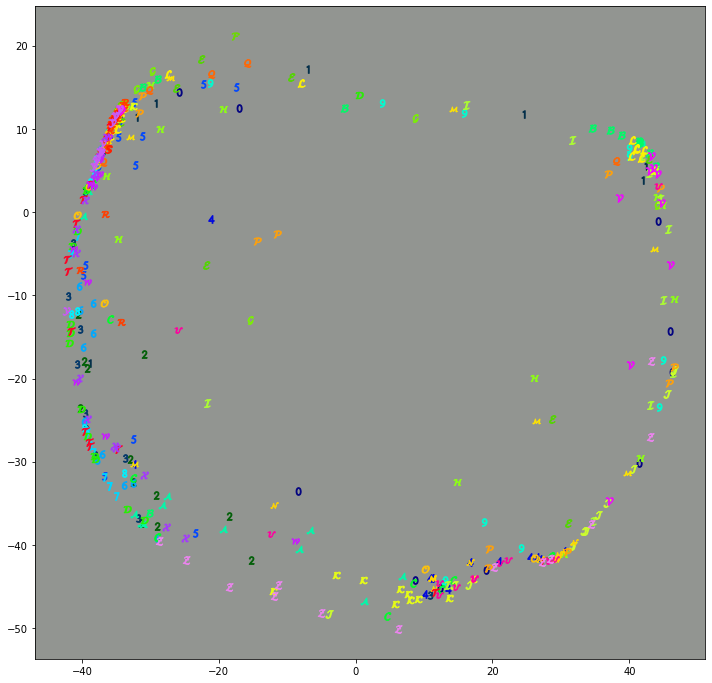

In [11]:
#Plot the 2D digit representations on a scatter plot from the x_test_2 dataset.
#Remember to use different colours for different digits!
y_adig_test = list(y_adig_test)
y_adig_test.sort()
label_pos = []
visited_labels = []
for i in range(len(y_adig_test)):
    if y_adig_test[i] not in visited_labels:
        label_pos.append(i)
        visited_labels.append(y_adig_test[i])
check_idx = lambda x: label_pos[x] if x<len(label_pos) else len(y_adig_test)

plt.figure(figsize=(12,12))
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired
colors = [colormap(i) for i in np.linspace(0, 0.9,36)]
for i in range(36):
    plt.scatter(sorted_points[check_idx(i) : check_idx(i+1)][:,0],
                sorted_points[check_idx(i) : check_idx(i+1)][:,1],
                label=str(i),
                s=60,
                marker='$\mathcal{'+y_adig[39*i]+'}$',
                c=np.array(colors[i]).reshape(1,-1),
                alpha=0.9)
ax = plt.gca()
ax.set_facecolor('xkcd:grey')
plt.show()

**Question (c)**

The fine tuned model is more loose in two dimensions and has better result. Randomly initialized weights are distributed at the edge, and the visualization is poor